In [1]:
size=192

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pydicom
from pydicom.pixel_data_handlers.util import convert_color_space

from PIL import Image
from skimage import io
import cv2

import tensorflow as tf

import albumentations

import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 15

from pathlib import Path

INPUT_PATH = Path("/kaggle/input/siim-isic-melanoma-classification")

# get the csvs ready 

In [4]:
train = pd.read_csv('../input/cluster-all/train.csv')
train['patient_id'] = train['patient_code'].astype('int')
test = pd.read_csv('../input/cluster-all/test.csv')
m1 = pd.read_csv('../input/cluster-all/m1.csv')
m1['patient_id'] = m1['patient_code'].astype('int')
m2 = pd.read_csv('../input/cluster-all/m2.csv')
# m2['patient_id'] = m2['patient_code']
m3 = pd.read_csv('../input/cluster-all/m3.csv')
# m3['patient_id'] = m3['patient_code']
m4 = pd.read_csv('../input/cluster-all/m4.csv')
# m4['patient_id'] = m4['patient_code']
ext_18 = pd.read_csv('../input/cluster-all/ext_18.csv')

# > # Write TFRecords - Train

In [5]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
def serialize_example(feature0, feature1, feature2,
                      feature3, feature4, feature5, feature6,
                      feature7,feature8,feature9,feature10,
                      ):
  feature = {
      'image': _bytes_feature(feature0),
      'image_name': _bytes_feature(feature1),
      'patient_id': _int64_feature(feature2),
      'sex': _int64_feature(feature3),
      'age_approx': _float_feature(feature4),
      'anatom_site_general_challenge': _int64_feature(feature5),
      'target': _float_feature(feature6),
      'diagnosis': _int64_feature(feature7),
      'width': _float_feature(feature8),
      'height': _float_feature(feature9),
      'cluster': _int64_feature(feature10),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [7]:
isic20all = [test]
for isic20 in isic20all:
    cols = isic20.columns
    # LABEL ENCODE ALL STRINGS
    cats = ['patient_id'] 
    for c in cats:
        isic20[c],mp = isic20[c].factorize()
        print(mp)
    isic20.age_approx.fillna(isic20.age_approx.mean(),inplace=True)    
    print('Imputing Age NaN count =',isic20.age_approx.isnull().sum())
test['patient_id'] = 100000+test['patient_id']

Index(['IP_6821261', 'IP_0652338', 'IP_2277592', 'IP_9834034', 'IP_1655674',
       'IP_0299921', 'IP_4896989', 'IP_7473498', 'IP_1233113', 'IP_7899071',
       ...
       'IP_9891374', 'IP_2205052', 'IP_9838814', 'IP_3028999', 'IP_0463575',
       'IP_6023641', 'IP_8336581', 'IP_8179715', 'IP_1790831', 'IP_8696724'],
      dtype='object', length=690)
Imputing Age NaN count = 0


In [8]:
ext_18

Unnamed: 0                image_name  patient_id      sex  age_approx  \
0               0              ISIC_0000002          -1   female        60.0   
1               1  ISIC_0000047_downsampled          -1     male        70.0   
2               2              ISIC_0000006          -1   female        25.0   
3               3  ISIC_0000060_downsampled          -1   female        35.0   
4               4  ISIC_0000031_downsampled          -1     male        70.0   
...           ...                       ...         ...      ...         ...   
12854       12854              ISIC_0034266          -1  unknown         NaN   
12855       12855              ISIC_0034268          -1   female        35.0   
12856       12856              ISIC_0034293          -1   female        55.0   
12857       12857              ISIC_0034304          -1     male        60.0   
12858       12858              ISIC_0034308          -1     male        30.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
0                   upper extremity       MEL        malignant     1.0   
1                   lower extremity        NV           benign     0.0   
2                   posterior torso        NV           benign     0.0   
3                   posterior torso        NV           benign     0.0   
4                   upper extremity       MEL        malignant     1.0   
...                             ...       ...              ...     ...   
12854                           NaN        NV           benign     0.0   
12855                anterior torso        NV           benign     0.0   
12856               lower extremity        NV           benign     0.0   
12857               posterior torso        NV           benign     0.0   
12858               upper extremity        NV           benign     0.0   

       tfrecord   width  height  patient_code  source  ext  cluster  
0           0.0  1022.0   767.0           NaN  ext_18  NaN       18  
1           2.0  1024.0   768.0           NaN  ext_18  NaN       21  
2           0.0  1022.0   767.0           NaN  ext_18  NaN       18  
3           2.0  1024.0   768.0           NaN  ext_18  NaN       18  
4           0.0  1024.0   768.0           NaN  ext_18  NaN       18  
...         ...     ...     ...           ...     ...  ...      ...  
12854      28.0   600.0   450.0           NaN  ext_18  NaN        6  
12855      28.0   600.0   450.0           NaN  ext_18  NaN        7  
12856      28.0   600.0   450.0           NaN  ext_18  NaN        2  
12857      28.0   600.0   450.0           NaN  ext_18  NaN       20  
12858      28.0   600.0   450.0           NaN  ext_18  NaN        2  

[12859 rows x 16 columns]

In [9]:
isic20 = pd.concat([train,test, m1, m2, m3, m4, ext_18])
cols = isic20.columns
# LABEL ENCODE ALL STRINGS
cats = ['sex','anatom_site_general_challenge', 'diagnosis'] 
isic20.diagnosis.replace('MEL',str('melanoma'),inplace=True) 
isic20.diagnosis.replace('NV',str('nevus'),inplace=True)
isic20.sex.replace('unknown',str(isic20.sex.mode().values[0]),inplace=True) 
for c in cats:
    isic20[c],mp = isic20[c].factorize()
    print(mp)
isic20.age_approx.fillna(isic20.age_approx.mean(),inplace=True)
isic20.sex.fillna(isic20.sex.mode(),inplace=True) 
print('Imputing Age NaN count =',isic20.age_approx.isnull().sum())
print('Imputing sex NaN count =',isic20.sex.isnull().sum())

Index(['male', 'female'], dtype='object')
Index(['head/neck', 'lower extremity', 'upper extremity', 'torso',
       'palms/soles', 'oral/genital', 'posterior torso', 'anterior torso',
       'lateral torso'],
      dtype='object')
Index(['unknown', 'nevus', 'melanoma', 'lentigo NOS', 'lichenoid keratosis',
       'seborrheic keratosis', 'atypical melanocytic proliferation',
       'solar lentigo', 'cafe-au-lait macule', 'basal cell carcinoma',
       'squamous cell carcinoma', 'BKL', 'BCC', 'VASC', 'AK', 'SCC', 'DF'],
      dtype='object')
Imputing Age NaN count = 0
Imputing sex NaN count = 0


In [10]:
train = isic20.query('source=="train"')
train.to_csv('train.csv')
test = isic20.query('source=="test"')
test.to_csv('test.csv')
m1 = isic20.query('source=="m1_c"')
m1.to_csv('m1.csv')
m2 = isic20.query('source=="m2_c"')
m2.to_csv('m2.csv')
m3 = isic20.query('source=="m3_c"')
m3.to_csv('m3.csv')
m4 = isic20.query('source=="m4_c"')
m4.to_csv('m4.csv')
ext_18 = isic20.query('source=="ext_18"')
ext_18.to_csv('ext_18.csv')

In [11]:
def gen_tf_rec(img_pths, isic_df,a):
    SIZE = 3000
    CT = len(img_pths)//SIZE + int(len(img_pths)%SIZE!=0)
    rec_count = 0
    for j in range(CT):
        print(); print('Writing TFRecord %i of %i...'%(j,CT))
        CT2 = min(SIZE,len(img_pths)-j*SIZE)
        with tf.io.TFRecordWriter('isic%str%.2i-%i.tfrec'%(a,j,CT2)) as writer:
             for k in range(CT2):
#                 img = centre_crop(img_pths[SIZE*j+k])
                
                img = cv2.imread(img_pths[SIZE*j+k])
    #             img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
                name = img_pths[SIZE*j+k].split('/')[-1].split('.')[0]
    #             print(name)
#                 try:
                row = isic_df.loc[isic_df.image_name==name]
                if not row.empty:
                    rec_count=rec_count+1
    #                 print(str(row.image_size.values[0]))

                    example = serialize_example(
                        img, str.encode(name),
                        row.patient_id.values[0],
                        row.sex.values[0],
                        row.age_approx.values[0],                        
                        row.anatom_site_general_challenge.values[0],
                        row.target.values[0],
                        row.diagnosis.values[0],
                        row.width.values[0],
                        row.height.values[0],
                        row.cluster.values[0]
                        )
                    writer.write(example)
                    if k%100==0:
                        print(k,', ',end='')
#                             jpgs = glob.glob('./*.jpg')
#                             for i in jpgs:
#                                 os.remove([i])
       
#                 except:
#                     pass
        if rec_count==len(img_pths):
            print('All '+str(rec_count)+' images recorded.')

In [12]:
# gen_tf_rec(img_path_2020, isic_2020_labelled,'20')

path = '../input/jpeg-melanoma-'+str(size)+'x'+str(size)+'/train/'
path_mal = '../input/malignant-v2-'+str(size)+'x'+str(size)+'/jpeg'+str(size)+'/'
path_ext = '../input/jpeg-isic2019-'+str(size)+'x'+str(size)+'/train/'
for i in tqdm(range(15)):
    img_name = train.query('tfrecord=='+str(i))['image_name'].tolist()
    img_namem1 = m1.query('tfrecord=='+str(i))['image_name'].tolist()
    img_namem2 = m2.query('tfrecord=='+str(i+15))['image_name'].tolist()
    img_namem3 = m3.query('tfrecord=='+str(i*2+1+30))['image_name'].tolist()
    img_namem4 = m4.query('tfrecord=='+str(i*2+30))['image_name'].tolist()
    img_name18 = ext_18.query('tfrecord=='+str(i*2))['image_name'].tolist()
#     train_img_paths = train['image_name'].tolist()
    train_img_paths = [path + img+'.jpg' for img in img_name]
    m1_img_paths = [path + img+'.jpg' for img in img_namem1]
    m2_img_paths = [path_mal + img+'.jpg' for img in img_namem2]
    m3_img_paths = [path_ext + img+'.jpg' for img in img_namem3]
    m4_img_paths = [path_ext + img+'.jpg' for img in img_namem4]
    ext_18_img_paths = [path_ext + img+'.jpg' for img in img_name18]
    
    gen_tf_rec(train_img_paths,
               train.query('tfrecord=='+str(i)),'20F'+str(i))
    gen_tf_rec(m1_img_paths,
               m1.query('tfrecord=='+str(i)),'_m1_'+str(i))
    gen_tf_rec(m2_img_paths,
               m2.query('tfrecord=='+str(i+15)),'_m2_'+str(i+15))
    gen_tf_rec(m3_img_paths,
               m3.query('tfrecord=='+str(i*2+1+30)),'_m3_'+str(i*2+1+30))
    gen_tf_rec(m4_img_paths,
               m4.query('tfrecord=='+str(i*2+30)),'_m4_'+str(i*2+30))
    gen_tf_rec(ext_18_img_paths,
               ext_18.query('tfrecord=='+str(i*2)),'_ext_18_'+str(i*2))


Writing TFRecord 0 of 1...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , All 2182 images recorded.

Writing TFRecord 0 of 1...
0 , All 38 images recorded.

Writing TFRecord 0 of 1...
0 , All 39 images recorded.

Writing TFRecord 0 of 1...
0 , All 76 images recorded.

Writing TFRecord 0 of 1...
0 , 100 , All 106 images recorded.

Writing TFRecord 0 of 1...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , All 858 images recorded.

Writing TFRecord 0 of 1...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , All 2185 images recorded.

Writing TFRecord 0 of 1...
0 , All 38 images recorded.

Writing TFRecord 0 of 1...
0 , All 39 images recorded.

Writing TFRecord 0 of 1...
0 , All 77 images recorded.

Writing TFRecord 0 of 1...
0 , 100 , All 109 images recorded.

Writing TFRecord 0 of 1...
0 , 100 , 200

In [13]:
# gen_tf_rec(img_path_2020, isic_2020_labelled,'20')
path = '../input/jpeg-melanoma-'+str(size)+'x'+str(size)+'/test/'
img_name = test['image_name'].tolist()
#     train_img_paths = train['image_name'].tolist()
test_img_paths = [path + img+'.jpg' for img in img_name]
gen_tf_rec(test_img_paths,test,'20test')


Writing TFRecord 0 of 4...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 
Writing TFRecord 1 of 4...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 
Writing TFRecord 2 of 4...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 
Writing TFRecord 3 of 4...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , All 10982 images recorded.


In [14]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [15]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['image_name']
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

There are 39 train images


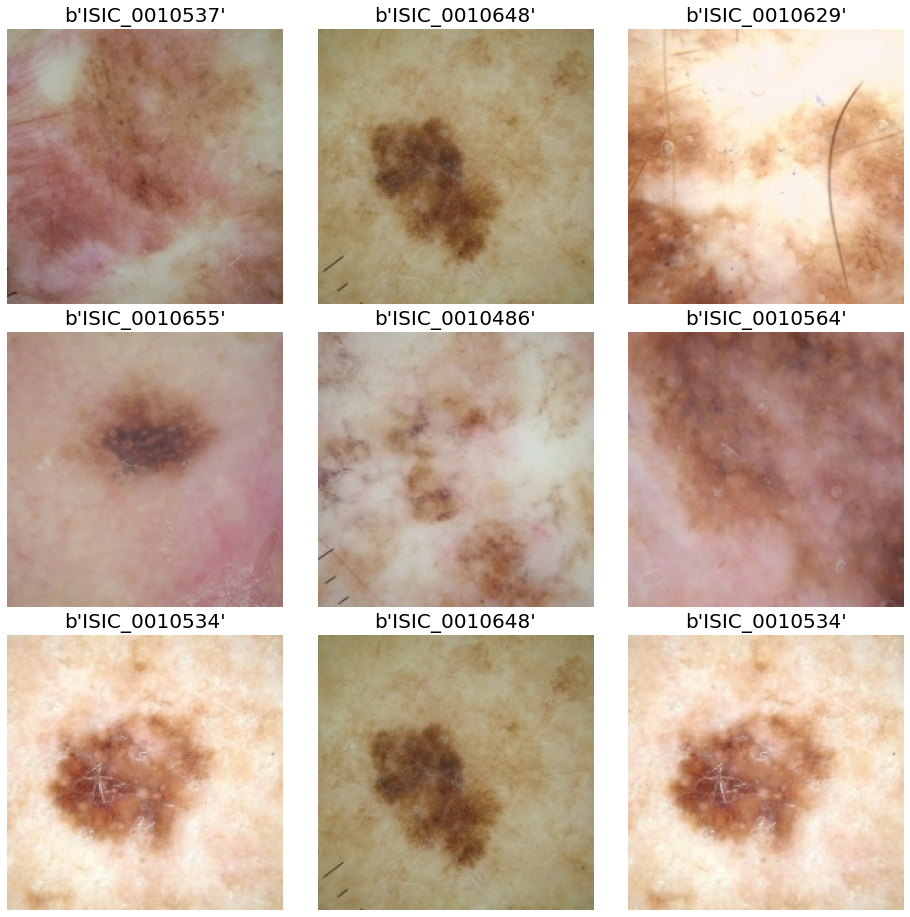

In [16]:
import re
import math
# INITIALIZE VARIABLES
IMAGE_SIZE= [size,size]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./isic_m2_18tr00-39.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))

There are 38 train images


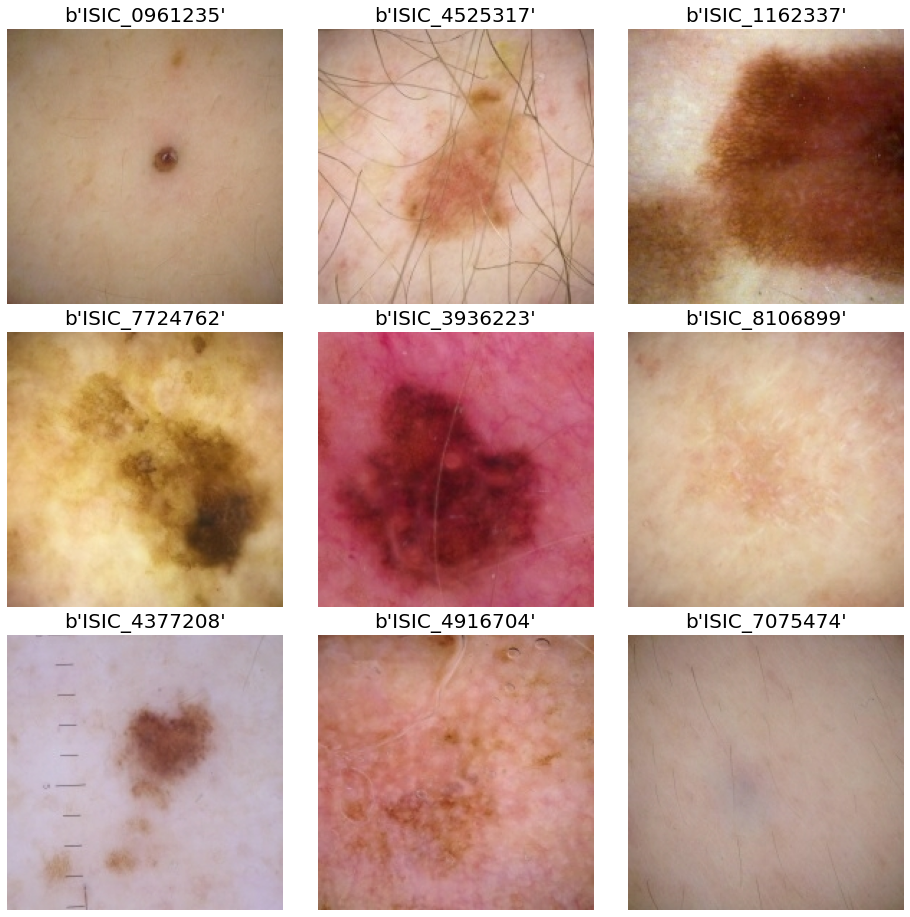

In [17]:
IMAGE_SIZE= [size,size]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./isic_m1_5tr00-38.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))

There are 39 train images


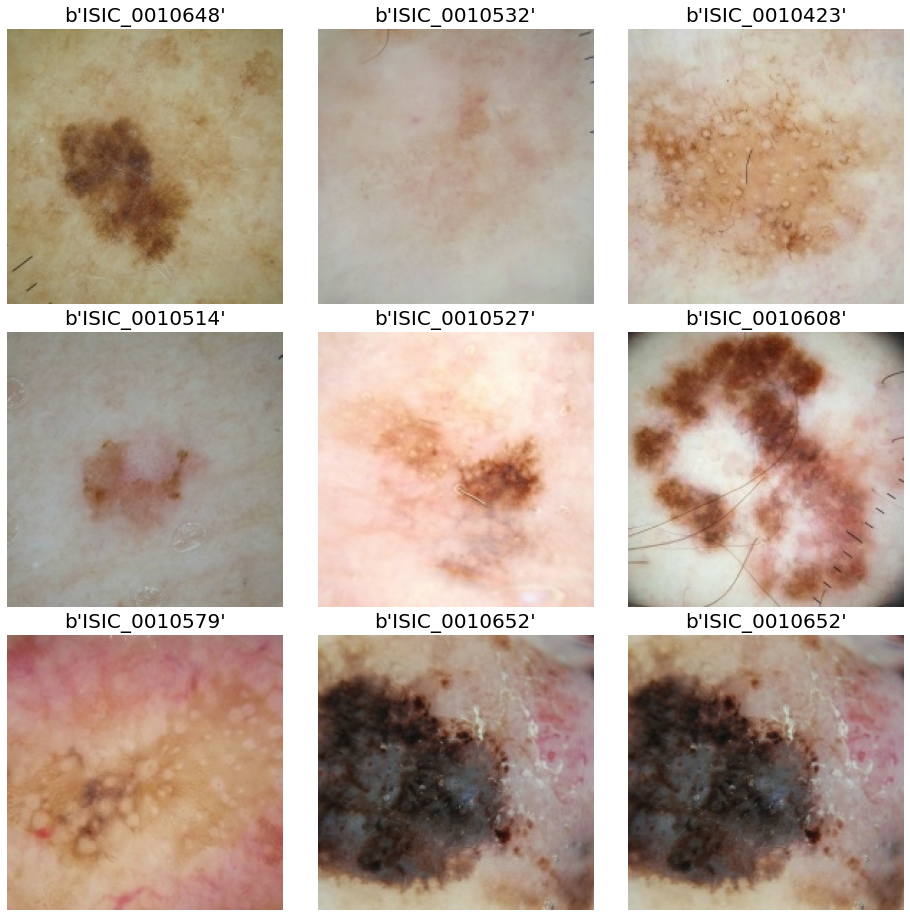

In [18]:
IMAGE_SIZE= [size,size]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./isic_m2_18tr00-39.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))

There are 858 train images


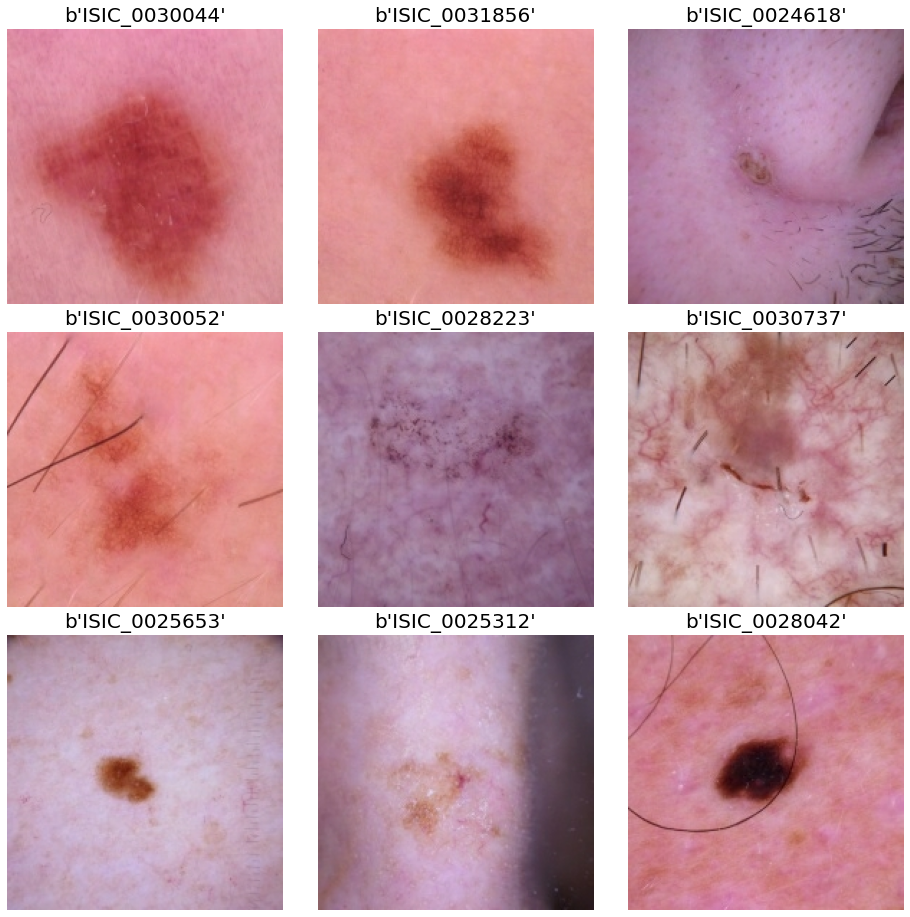

In [19]:
IMAGE_SIZE= [size,size]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./isic_ext_18_2tr00-858.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))

There are 3000 train images


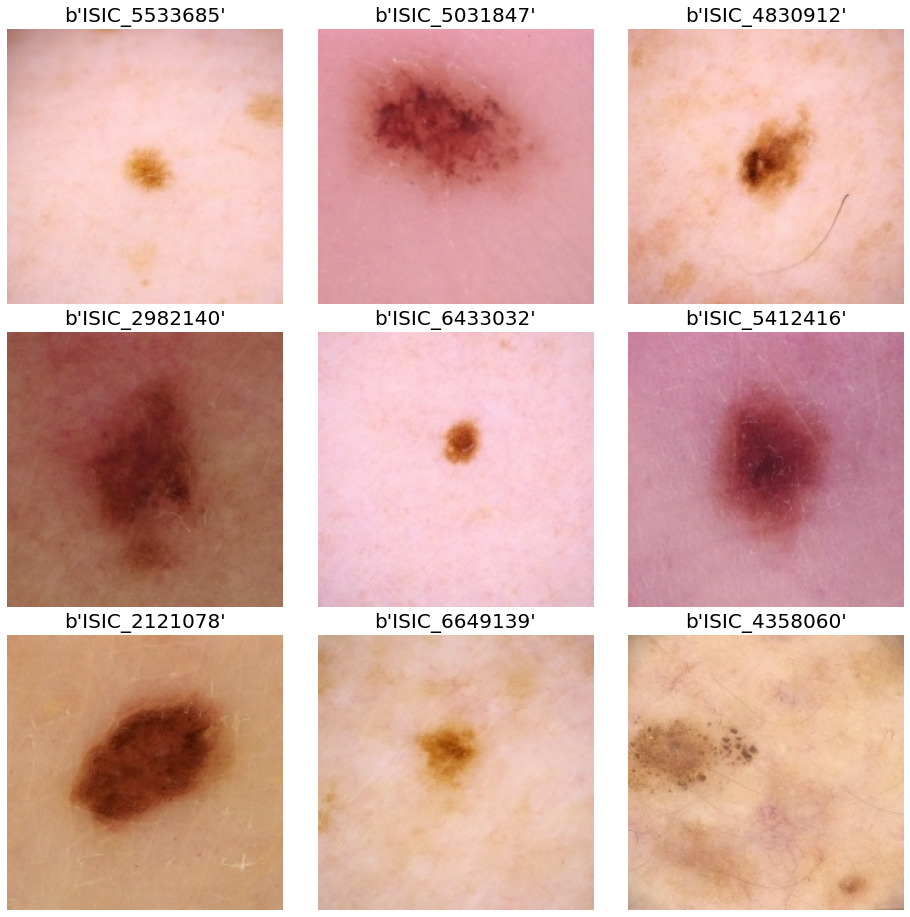

In [20]:
IMAGE_SIZE= [size,size]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./isic20testtr00-3000.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))